<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/main/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4 : Approximation**
**Marc Hétier**

# **Abstract**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [14]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [15]:
# Load neccessary modules.
# from google.colab import files
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# **Introduction**

In this lab, we work on the approximation of function. The general background is an Hilbert space of function $V \subset \mathcal{L}^2(I)$, provided with the classical inner product :
$$(f, g) = \int_I f(x)g(x) dx $$

We also consider a subspace $V_N$ of $V$, of finite dimension $N$, and we search the projection of a function $f \in V$ on $V_N$. We note $P_Nf$ this projection.

Given a basis $\{\phi_i\}_{i = 1, \ldots ,N}$ of $V_N$, searching for $P_Nf$ is equivalent at searching its sets of coordinates $\{\alpha_j\}_{j = 1, \ldots ,N}$ such that 
$$ \forall i \;\;\; \sum_{j=1}^N \alpha_j (\phi_j, \phi_i) = (f, \phi_i) $$

This last equation is equivalent at the linear system
$$ A \alpha = b$$
where $\alpha = (\alpha_i)_i$, $A = ((\phi_j, \phi_i))_{i,j}$ and $b = (f, \phi_i)_i$.

Being able to find the projection of a function $f$ on a subspace is necessary to solve FEM problem. Then, the first part of our work will be dedicated to solving projection problem, and the second part will use this to solve a Poisson equation.

# **Method**

## Problem 1 : L2 projection to pw linear approwimation over a 1D mesh

In the following part, we assume that we are working with scalars functions. We also subdivise the interval $I$ into a mesh $(x_i)_{i=0}^{m+1}$ and we assume that it exists two families of basis. The first one consists of local basis for each sub-interval $[x_i, x_{i+1}]$, and the second one consists of a unique global basis for the entire interval $I$. More rigoursly, we define :
- for each $I_k$, a basis $(\lambda_{k,j})_{j =0}^{L_k}$
- the global basis function $(\phi_i)_i$, define using the local basis functions. This definition changes with the $(L_k)_k$ and if we want, or not a continuous approximation.

We create a function *assemble_system* which takes as input the function we want to approximate, the mesh and the local basis function. It returns the matrix $A$, $\alpha$ and $b$ define above.
This function is very global, and use some sub functions which highly depends on the local basis we used, and if we want, or not, a continuous approximation. For those reasons, they are also pass as parameters.



In [16]:
def assemble_solve_system(f, local_basis, get_local_to_global, integrate_vector, integrate_matrix, add_to_glob_vec, \
                                    add_to_glob_matrix, final_size):
    """
    Input : a function f, a mesh under the form [x_0, ..., x_m+1] and
        list of local basis [[lambda_{k,1},..., lambda_{k,L_k}]...]
    Output : matrix A and b of the system
    """


    A = np.zeros((final_size, final_size))
    b = np.zeros(final_size)
    for k in range(0,len(local_basis)):
        Lk = len(local_basis[k])
        loc2glob = get_local_to_global(k)

        b_k = np.zeros(Lk)
        A_k = np.zeros((Lk,Lk))
        for i in range(0,Lk):
            b_k[i] = integrate_vector(f, local_basis[k][i])
            for j in range(0,Lk):
                A_k[i,j] = integrate_matrix(local_basis[k][i], local_basis[k][j])
        add_to_glob_matrix(A, A_k, loc2glob)
        add_to_glob_vec(b, b_k, loc2glob)
    
    alpha = np.linalg.solve(A,b)
    return A, alpha, b


To see how this function work, we need more material. First, we define a mesh on $I = [0, 1]$, and basis function which correspond to $\lambda_{k,i}$ given in example 9.6. We also define all the function needed to assemble the system, corresponding at an approximation of $V_h(I)$.

In [17]:
m = 5
mesh = np.linspace(0,1, m+2) #m+2 point into the interval;

def lambda_0(x, x_k_1, x_k):
    if x_k_1 <= x <= x_k:
        return (x_k - x)/(x_k-x_k_1)
    else:
        return 0
def lambda_1(x, x_k_1, x_k):
    if x_k_1 <= x <= x_k:
        return (x - x_k_1)/(x_k-x_k_1)
    else:
        return 0

def get_local_to_global(k):
    return k

## Ideally, we define a vector local basis as follow, but it does not work
# local_basis = np.array([[lambda x:lambda_0(x, mesh[k], mesh[k+1]), lambda x:lambda_1(x, mesh[k], mesh[k+1])] \
#                 for k in range(0,m+1)])

# the vector will only contains the bounds x_k_1, x_k and the number 0 or 1

local_basis = np.array([[(0, mesh[k], mesh[k+1]), (1, mesh[k], mesh[k+1])] for k in range(0,m+1)])


def integrate_vector(f, fct_basis_k):
    """
    Compute the integral between f and the fct_basis given in input
    """
    x_k_1, x_k = fct_basis_k[1], fct_basis_k[2]
    def product(x):
        if fct_basis_k[0] == 0:
            return f(x)*lambda_0(x, x_k_1, x_k)
        if fct_basis_k[0] == 1:
            return f(x)*lambda_1(x, x_k_1, x_k)
    rslt = scipy.integrate.quad(product, x_k_1, x_k)
    return rslt[0]


def integrate_matrix(fct_basis_i, fct_basis_j):
    """
    Compute the integral between two basis functions
    """
    x_k_1, x_k = fct_basis_j[1], fct_basis_i[2]
    def product(x):
        if fct_basis_i[0] == 0:
            if fct_basis_j[0] == 0:
                return lambda_0(x, x_k_1, x_k)**2
            if fct_basis_j[0] == 1:
                return lambda_0(x, x_k_1, x_k)*lambda_1(x, x_k_1, x_k)
        if fct_basis_i[0] == 1:
            if fct_basis_j[0] == 0:
                return lambda_0(x, x_k_1, x_k)*lambda_1(x, x_k_1, x_k)
            if fct_basis_j[0] == 1:
                return lambda_1(x, x_k_1, x_k)**2
    return scipy.integrate.quad(product, x_k_1, x_k)[0]


def add_to_glob_matrix(A, A_k, k):
    """
    We need to correctly add the local term in the global matrix
    """
    Lk = A_k.shape[0]
    A[k:k+Lk, k:k+Lk] += A_k
    # A[k,k] += A_k[0,0]            ## version when I first submitted
    # A[k+1, k+1] += A_k[1,1]
    # A[k, k+1] += A_k[0,1]
    # A[k+1,k] += A_k[1,0]
    return None

def add_to_glob_vec(b, b_k, k):
    Lk = b_k.shape[0]
    b[k:k+Lk] += b_k
    # b[k] += b_k[0]
    # b[k+1] += b_k[1]
    return None


Now, we can test our approximation on function. For example, if we want to approximate $\sin$ :

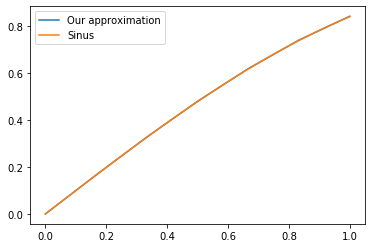

In [18]:
sol_exact = np.sin(np.linspace(0,1, 200))
A, alpha, b = assemble_solve_system(np.sin, local_basis, get_local_to_global, \
                integrate_vector, integrate_matrix, add_to_glob_vec, add_to_glob_matrix, m+2)

plt.plot(mesh, alpha)
plt.plot(np.linspace(0,1, 200), sol_exact)
plt.legend(("Our approximation", "Sinus"))
plt.show()

We can also compute the $L^2$ norm between the approximation and the function :

In [19]:
print(np.linalg.norm(alpha-np.sin(mesh)))

0.0032555861158849436


It does not appear very low, but we only used a 7 points mesh ! We can consider that the approximation is really good.

## Problem 3 :  Solution to the Poisson's equation
We consider the following ODE :
\begin{equation}
\begin{array}{l}
- u'' = f  \text{           on } [0,1]\\
u(0) = u(1) = 0 \\
\end{array}
\end{equation}

We will take $f(x) = \sin(2\pi x)$. The solution is then quite obvious, equal at $u(x) = \frac{1}{4\pi^2} sin(2\pi x)$. We can also pretend do not know it, and solve this equation using finite element methods. It consists to search the solution $u$ on a finite space $V_N$ such that the residual is orthogonal to a basis of $V_N$. Under a mathematical form, we note $(\phi_i)_i$ a basis of $V_N$ and we search $u = \sum_{i=1}^N \alpha_i \phi_i$ such that :
$$\forall i \;\; \int_0^1 (u'' + f) \phi_i = 0$$

Finding $u$ is equivalent at finding its coordinates. Moreover, using integration by parts and the boundary conditions, the coefficients $\alpha_i$ verify :
$$ \forall i \;\; - \sum_{j=1}^N \alpha_j \int_0^1 \phi_i' \phi_j' = \int_0^1 f \phi_i $$
This equation can be written under a matrix form :
$$ A \alpha = b $$

We find back the previous problem, and will use the function assemble_solve_system to solve it. However, we need to redefine the auxiliary functions integrate_matrix.

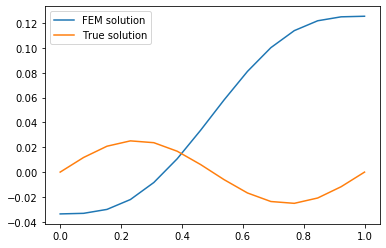

In [20]:
m = 12
mesh = np.linspace(0,1, m+2) #m+2 point into the interval;

local_basis = np.array([[(0, mesh[k], mesh[k+1]), (1, mesh[k], mesh[k+1])] for k in range(0,m+1)])

def dlambda_0(x, x_k_1, x_k):
    """ Derivative of lambda_0 """
    if x_k_1 <= x <= x_k:
        return -1/(x_k - x_k_1)
    else:
        return 0

def dlambda_1(x, x_k_1, x_k):
    """ Derivative of lambda_1 """
    if x_k_1 <= x <= x_k:
        return 1/(x_k - x_k_1)
    else:
        return 0

def integrate_matrix_fem(fct_basis_i, fct_basis_j):
    """
    Compute the integral between the derivative of two basis functions
    """
    x_k_1, x_k = fct_basis_j[1], fct_basis_i[2]
    def product(x):
        if fct_basis_i[0] == 0:
            if fct_basis_j[0] == 0:
                return dlambda_0(x, x_k_1, x_k)**2
            if fct_basis_j[0] == 1:
                return dlambda_0(x, x_k_1, x_k)*dlambda_1(x, x_k_1, x_k)
        if fct_basis_i[0] == 1:
            if fct_basis_j[0] == 0:
                return dlambda_0(x, x_k_1, x_k)*dlambda_1(x, x_k_1, x_k)
            if fct_basis_j[0] == 1:
                return dlambda_1(x, x_k_1, x_k)**2
    return scipy.integrate.quad(product, x_k_1, x_k)[0]


sin2pi = lambda x:np.sin(2*np.pi*x)
A, alpha, b = assemble_solve_system(sin2pi, local_basis, get_local_to_global, integrate_vector, \
                        integrate_matrix_fem, add_to_glob_vec, add_to_glob_matrix, m+2)

plt.plot(mesh, -alpha)
plt.plot(mesh, 1/(4*np.pi**2)*np.sin(mesh*2*np.pi))
plt.legend(("FEM solution", "True solution"))

As we can see, the FEM solution is not good. In fact, I really do not understand why. The matrix $A$ generated seems correct (main part equal at $Tridiag(-1/h, 2/h, -1/h)$), and the vector $b$ is computed as before. Moreover, for some value of $m$ (for example $m=100$), when we try to solve $A \alpha = b$ we obtain an error for singular matrix $A$. I certainly miss something, but I do not see what.

In [21]:
print(2/mesh[1])
print(A)

26.0
[[ 13. -13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-13.  26. -13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -13.  26. -13.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -13.  26. -13.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -13.  26. -13.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -13.  26. -13.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -13.  26. -13.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -13.  26. -13.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -13.  26. -13.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -13.  26. -13.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -13.  26. -13.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -13.  26. -13.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -13.  26. -13.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

## Correct version for Problem 3 :
After some discussion with Johan, it appears that I forgot to change the basis of local function. The one I used does not respect the boundary condition of the problem, and therefore can not be used. It will generated a solution with homogenous Neuman condition, instead of homogenous Dirichlet condition. Moreover, the Poisson equation with Neuman condition is ill posed, which explain why the matrix was sometimes singular.

For the correct version, the basis should exclude $\lambda_{0,0}$ and $\lambda_{m+1, 1}$. We also need to change the function *get_local_to_global* and I made some change on function *add_to_glob_matrix* to make them more global.

Note that the size of matrix $A$ and vector $b$ have also been reduced by 2, since we loose 2 degrees of freedom by removing the incorrect basis functions.

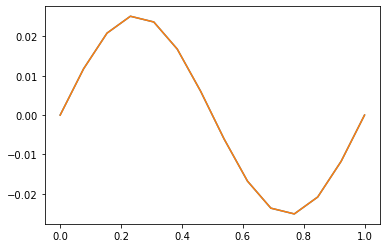

In [22]:
def get_local_to_global_fem(k):
    if k == 0:
        return 0
    else:
        return k-1

central_basis = [[(0, mesh[k], mesh[k+1]), (1, mesh[k], mesh[k+1])] for k in range(0,m+1)]
central_basis[0] = [(1, mesh[0], mesh[1])]
central_basis[m] = [(0, mesh[m], mesh[m+1])]
correct_local_basis = np.array(central_basis)


A, alpha, b = assemble_solve_system(sin2pi, correct_local_basis, get_local_to_global_fem, integrate_vector, \
                        integrate_matrix_fem, add_to_glob_vec, add_to_glob_matrix, m)

alpha = np.concatenate(([0], alpha, [0]))
plt.plot(mesh, 1/(4*np.pi**2)*np.sin(mesh*2*np.pi))
plt.plot(mesh, alpha)

And we can see that the two solutions perfectly fit !